In [ ]:
# packages
!pip install gensim==3.8.3

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gensim.downloader
from gensim.models import Word2Vec
import nltk.data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
import logging
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import decomposition
print(gensim.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
3.8.3


In [ ]:
# get data
url = "https://raw.githubusercontent.com/soujanyaporia/MUStARD/master/data/sarcasm_data.json"
df = pd.read_json(url,orient='index')


,utterance,speaker,context,context_speakers,show,sarcasm
160,It's just a privilege to watch your mind at work.,SHELDON,[I never would have identified the fingerprint...,"[LEONARD, SHELDON]",BBT,True
170,I don't think I'll be able to stop thinking ab...,PENNY,[This is one of my favorite places to kick bac...,"[HOWARD, PENNY, HOWARD, HOWARD, HOWARD, PENNY,...",BBT,True
180,"Since it's not bee season, you can have my epi...",SHELDON,"[Here we go. Pad thai, no peanuts., But does i...","[LEONARD, HOWARD, LEONARD]",BBT,False
190,"Lois Lane is falling, accelerating at an initi...",SHELDON,[A marathon? How many Superman movies are ther...,"[PENNY, SHELDON, PENNY, SHELDON, SHELDON, PENN...",BBT,False
1105,I'm just inferring this is a couch because the...,SHELDON,"[Great Caesar's ghost, look at this place., So...","[SHELDON, LEONARD, SHELDON, SHELDON, SHELDON, ...",BBT,True


In [ ]:
# first time: feature extraction
# w10 lab

nltk.download('punkt')
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    
    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

wv = gensim.downloader.load('word2vec-google-news-300')
wv.init_sims(replace=True)
print('Model loaded')
file = open('drive/MyDrive/proj/wv_gnews300_383', 'wb')
pickle.dump(wv, file)
file.close()

tokenized_utterance = df.apply(lambda r: w2v_tokenize_text(r['utterance']), axis=1).values
average_utterance = word_averaging_list(wv,tokenized_utterance)
file = open('drive/MyDrive/proj/wv_utterance', 'wb')
pickle.dump(average_utterance, file)
file.close()

tokenized_context = df.apply(lambda r: w2v_tokenize_text(" ".join(r['context']), axis=1)).values
average_context = word_averaging_list(wv,tokenized_context)
file = open('drive/MyDrive/proj/wv_context', 'wb')
pickle.dump(average_context, file)
file.close()                       

Model loaded
CPU times: user 1min 2s, sys: 8.98 s, total: 1min 11s
Wall time: 1min 23s


In [ ]:
# second time: load features
file = open('drive/MyDrive/proj/wv_utterance', 'rb')
average_utterance = pickle.load(file)
file.close()

file = open('drive/MyDrive/proj/wv_context', 'rb')
average_context = pickle.load(file)
file.close()

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(np.concatenate([average_utterance, average_context], axis=1), df["sarcasm"], test_size=0.3, random_state = 42)


In [ ]:
# evaluate 
clf = SVC()
svm = clf.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.57      0.70      0.63        94
        True       0.70      0.57      0.62       113

    accuracy                           0.63       207
   macro avg       0.63      0.63      0.63       207
weighted avg       0.64      0.63      0.63       207



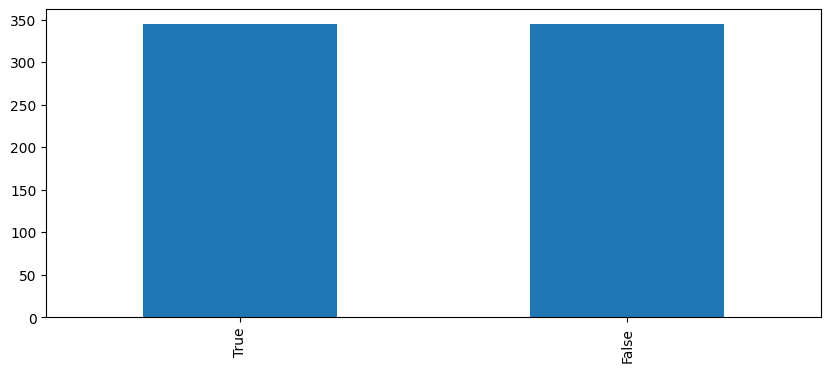

In [ ]:
# visualize data
df.head(5)
plt.figure(figsize=(10,4))
df["sarcasm"].value_counts().plot(kind='bar');

In [ ]:
# pca preprocessing
pca = decomposition.PCA(n_components=1)
pca.fit(average_utterance)
pca_utterance = pca.transform(average_utterance)

pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_utterance, df["sarcasm"], test_size=0.3, random_state = 42)


pca_clf = SVC()
pca_svm = pca_clf.fit(pca_X_train, pca_y_train)
pca_y_pred = pca_svm.predict(pca_X_test)

print(classification_report(pca_y_test, pca_y_pred))